In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

# Modelselektion

Wir konstruieren Daten rund um ein Polynom 3. Grades und fitten diverse Polynome.

### Datenerzeugung

In [2]:
def true_function(x):
    return 100*(x-0.2)*(x-0.4)*(x-0.8)

rng = np.random.default_rng(seed=42) # Zufallszahlengenerator initialisieren

x = np.sort(rng.uniform(low=0.0, high=1.0, size=50))
x = x[(x < 0.4) | (x > 0.5)] # cut out some values
y = true_function(x) + 0.8*rng.normal(size=len(x))


x_support = np.linspace(start= x.min(), stop= x.max(), num= 200)
y_true = true_function(x_support)

y_range = y.max()- y.min()
ylim =(y.min() - 0.1*y_range, y.max() + 0.1*y_range)

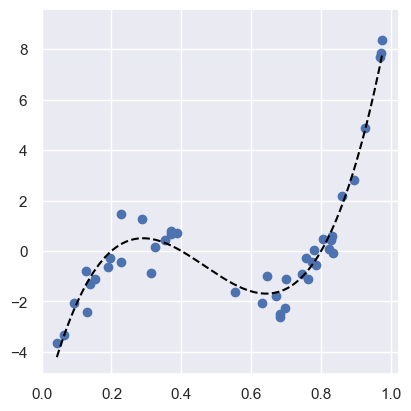

In [3]:
sns.set_theme()
fig, ax = plt.subplots(figsize= (4, 4), layout="constrained")
ax.scatter(x, y)
ax.plot(x_support, y_true, color="black", linestyle="--")
ax.set(ylim=ylim)
plt.show()

### Polynome unterschiedlichen Grades fitten

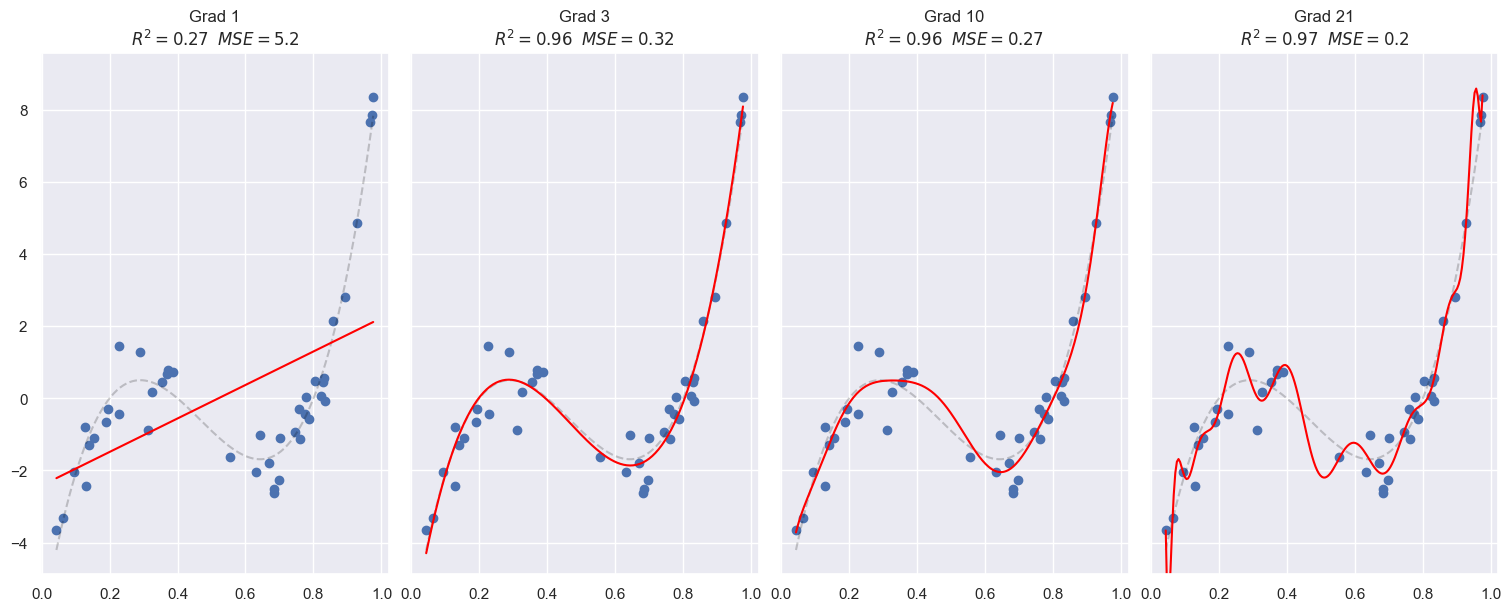

In [4]:
degrees = [1, 3, 10, 21]

fig, axs = plt.subplots(1, len(degrees), sharey=True, figsize=(15, 6), layout="constrained")

for degree in range(len(degrees)):
    pipeline = Pipeline([
        ("polynomial_features", PolynomialFeatures(degree=degrees[degree], include_bias=False)), 
        ("linear_regression", LinearRegression())
        ])
    
    pipeline.fit(x.reshape(-1, 1), y)
    y_pred = pipeline.predict(x_support.reshape(-1, 1))
    
    R2 = pipeline.score(x.reshape(-1, 1), y)
    MSE = mean_squared_error( y_true= y, y_pred= pipeline.predict(x.reshape(-1, 1)))
    
    axs[degree].scatter(x, y, label="Samples")
    axs[degree].plot(x_support, y_true, color="black", linestyle="--", alpha = 0.2) # Wahrheit
    axs[degree].plot(x_support, y_pred, color="red") # Modell
    axs[degree].set(ylim=ylim, title="Grad {}\n$R^2={:.2}$  $MSE={:.2}$".format(degrees[degree], R2, MSE))

plt.show()
fig.savefig("poly_regression_overfitting.png")

### Split in Trainings- und Testdatensatz

In [5]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.35, random_state=42)

print(x.shape, y.shape)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(43,) (43,)
(27,) (27,)
(16,) (16,)


Gesplittete Daten plotten

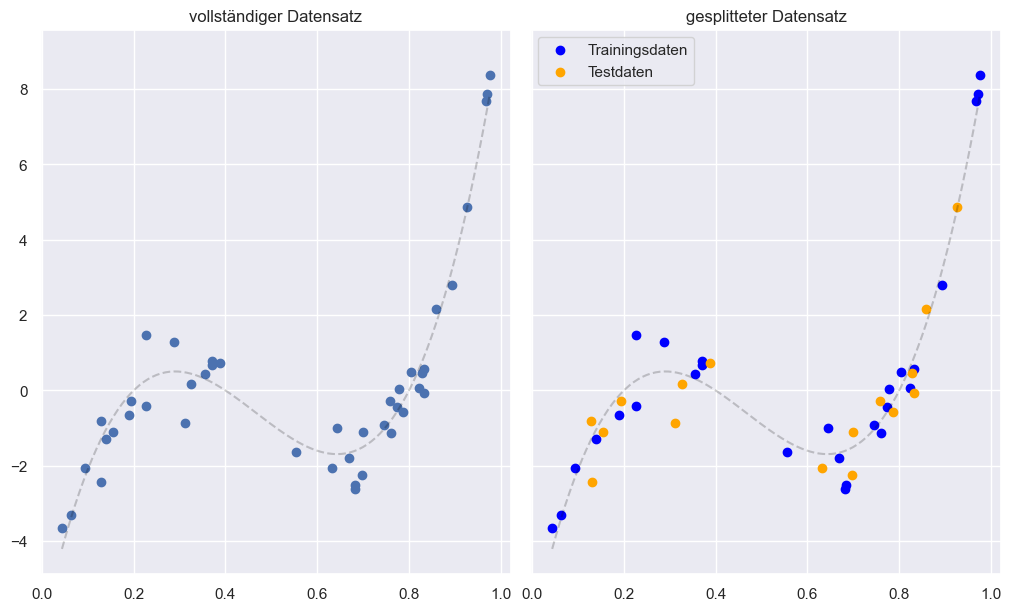

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(10, 6), sharey=True, layout="constrained")
axs[0].scatter(x, y)
axs[0].plot(x_support, y_true, color="black", linestyle="--", alpha = 0.2)
axs[0].set(ylim=ylim, title="vollständiger Datensatz")

axs[1].scatter(x_train, y_train, color="blue", label="Trainingsdaten")
axs[1].scatter(x_test, y_test, color="orange", label="Testdaten")
axs[1].plot(x_support, y_true, color="black", linestyle="--", alpha = 0.2)
axs[1].set(ylim=ylim, title="gesplitteter Datensatz")
axs[1].legend()

fig.savefig("split_data.png")
plt.show()

Für einige Polynomgerde sowohl trainieren als auch auf Testdaten evaluieren.

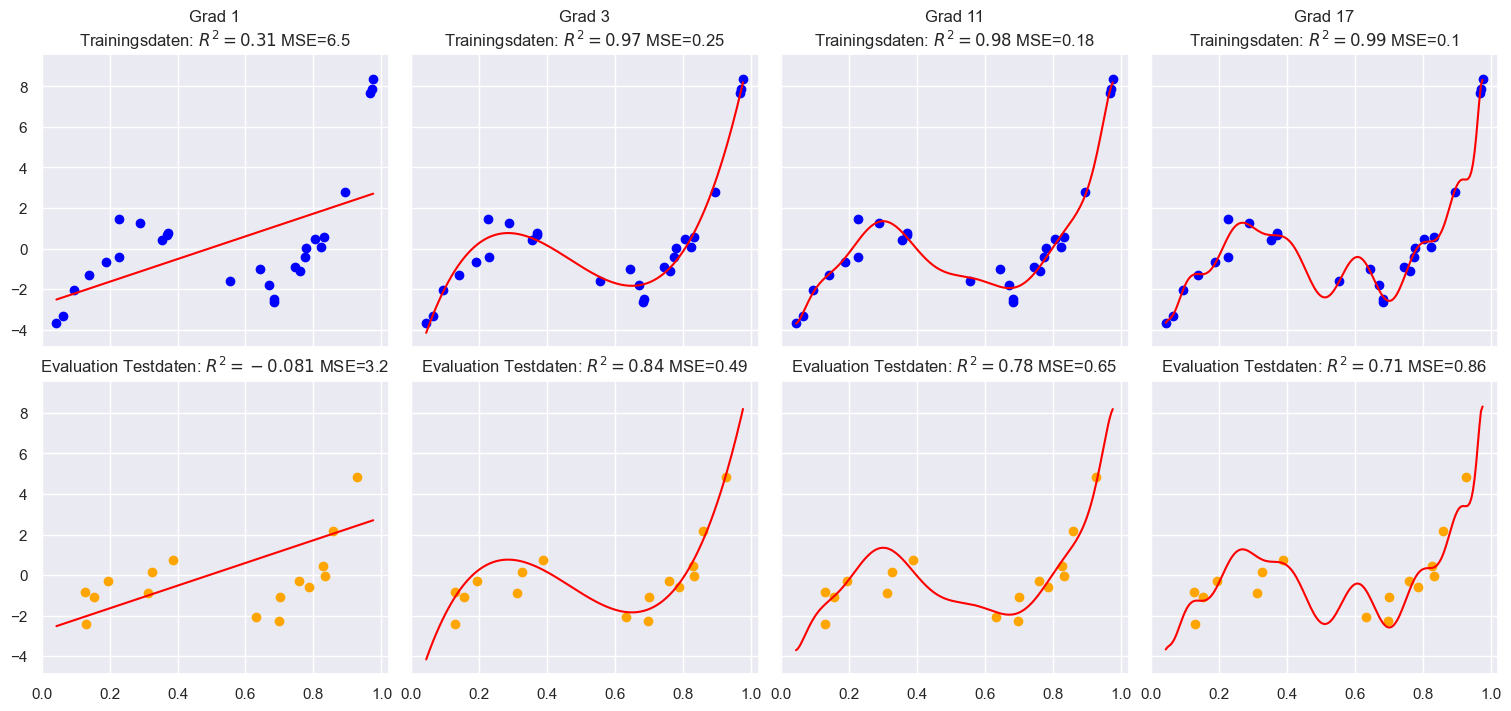

In [7]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.35, random_state=42)

degrees = [1, 3, 11, 17]

fig, axs = plt.subplots(2, len(degrees), sharex=True, sharey=True, figsize=(15, 7), layout="constrained")

for degree in range(len(degrees)):
    pipeline = Pipeline([
        ("polynomial_features", PolynomialFeatures(degree=degrees[degree], include_bias=False)), 
        ("linear_regression", LinearRegression())
        ])

    pipeline.fit(x_train.reshape(-1, 1), y_train)
    y_pred = pipeline.predict(x_support.reshape(-1, 1))
    
    R2_train  = pipeline.score(x_train.reshape(-1, 1), y_train)
    R2_test   = pipeline.score(x_test.reshape(-1, 1),  y_test)

    MSE_train = mean_squared_error(y_true= y_train, y_pred= pipeline.predict(x_train.reshape(-1, 1)))
    MSE_test  = mean_squared_error(y_true= y_test,  y_pred= pipeline.predict(x_test.reshape(-1, 1)))
    
    # plot training
    axs[0, degree].scatter(x_train, y_train, color="blue", label="Trainingsdaten")
    axs[0, degree].plot(x_support, y_pred, color="red", label="Modell")
    axs[0, degree].set(ylim=ylim , title="Grad {}\nTrainingsdaten: $R^2={:.2}$ MSE={:.2}".format(degrees[degree], R2_train, MSE_train))

    # plot testing
    axs[1, degree].scatter(x_test, y_test, color="orange", label="Testdaten")
    axs[1, degree].plot(x_support, y_pred, color="red", label="Modell")
    axs[1, degree].set(ylim=ylim , title="Evaluation Testdaten: $R^2={:.2}$ MSE={:.2}".format(R2_test, MSE_test))

plt.show()
fig.savefig("poly_regression_train_test.png")

Nun systematisch alle Polynomgrade durchgehen und jeweils $R^2$ sowie Mean-Squared-Error auf der Testmenge bestimmen.

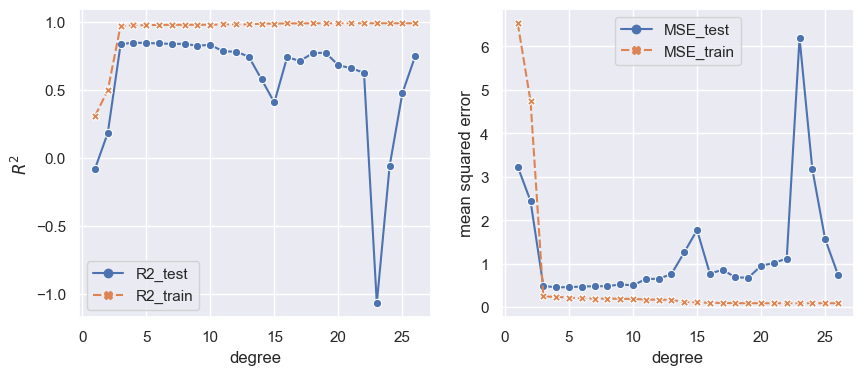

In [8]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.35, random_state=42)

scores = []

for degree in range(1, len(x_train)):
    pipeline = Pipeline([
        ("polynomial_features", PolynomialFeatures(degree=degree, include_bias=False)), 
        ("linear_regression", LinearRegression())
        ])
    
    pipeline.fit(x_train.reshape(-1, 1), y_train)

    R2_train  = pipeline.score(x_train.reshape(-1, 1), y_train)
    R2_test   = pipeline.score(x_test.reshape(-1, 1),  y_test)

    MSE_train = mean_squared_error(y_true= y_train, y_pred= pipeline.predict(x_train.reshape(-1, 1)))
    MSE_test  = mean_squared_error(y_true= y_test,  y_pred= pipeline.predict(x_test.reshape(-1, 1)))

    scores.append({"degree": degree, "R2_train": R2_train, "R2_test": R2_test, "MSE_train": MSE_train, "MSE_test": MSE_test})

scores_df = pd.DataFrame.from_records(scores).set_index("degree")

fig, axs = plt.subplots(1, 2, figsize=(10, 4))
sns.lineplot(ax=axs[0], data= scores_df[["R2_test", "R2_train"]], markers=True)
axs[0].set_ylabel("$R^2$")
sns.lineplot(ax=axs[1], data= scores_df[["MSE_test", "MSE_train"]], markers=True)
axs[1].set_ylabel("mean squared error")
plt.show()

Im obigen Bild erkennt man, dass ein Polynomgrad im Bereich 2 bis 10 wohl geeignet wäre.

Die konkreten Zahlenwerte der obigen Kurve hängen allerdings noch sehr vom jeweiligen Split in Trainings- und Testdaten ab.
Falls man zufällig einen ungünstigen Split gewählt hat, kann die Kurve stark verrauscht sein.

Besser ist eine mehrfache Wiederholung auf unterschiedlichen Test- und Trainingsmengen, z.B. Kreuzvalisierung.

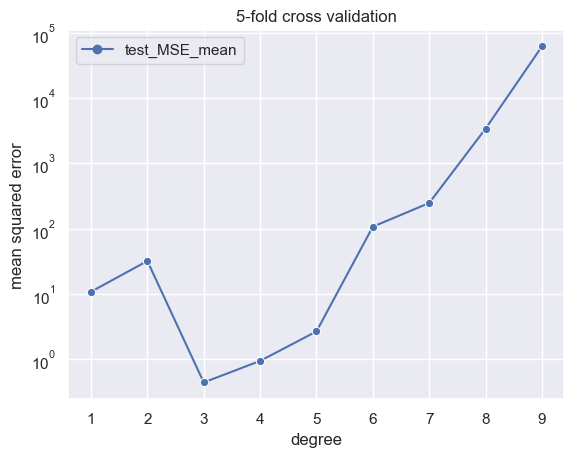

In [9]:
scores = []

for degree in range(1, 10):
    pipeline = Pipeline([
        ("polynomial_features", PolynomialFeatures(degree=degree, include_bias=False)), 
        ("linear_regression", LinearRegression())
        ])

    cv_scores = cross_val_score(
        pipeline, x.reshape(-1,1), y, 
        cv=5, scoring="neg_mean_squared_error" # alternativ: scoring = "r2"
    ) 
    
    scores.append({"degree": degree, "test_MSE_mean": -cv_scores.mean()})

scores_df = pd.DataFrame.from_records(scores).set_index("degree")
scores_df

ax = sns.lineplot(data= scores_df, markers=True)
ax.set(yscale = "log", ylabel="mean squared error", title="5-fold cross validation")
plt.show()

Im obigen Bild erkennt man, dass der Polynomgrad 3 (evtl. 4 oder 5) am besten ist.

Sehr viel komfortabler geht das alles mit einem systematischen kreuzvalidiereten GridSearch über eine vorgegebene Menge von möglichen Parametern:

In [10]:
pipeline = Pipeline([
        ("polynomial_features", PolynomialFeatures(include_bias=False)), 
        ("linear_regression", LinearRegression())
        ])

parameters = {'polynomial_features__degree': np.arange(1, 10)}
search = GridSearchCV(pipeline, parameters)
search.fit(X= x.reshape(-1,1), y=y)
print(search.best_params_, search.best_score_)

{'polynomial_features__degree': 3} 0.17510508411786746
